In [209]:
import pandas as pd
import numpy as np
robo1data = pd.read_csv('Robot1',sep='\s+',header=None,names = ['class','a1','a2','a3','a4','a5','a6','Id'],index_col = False)
by_class = robo1data.groupby('class')
classOneData = by_class.get_group(1)
classZeroData = by_class.get_group(0)
ran1 = np.random.rand(len(classOneData)) < 0.8
ran2 = np.random.rand(len(classZeroData)) < 0.8
trainClassOne = classOneData.sample(frac=0.8)
trainClassZero = classZeroData.sample(frac=0.8)
valClassOne = classOneData.loc[~classOneData.index.isin(trainClassOne.index)]
valClassZero = classZeroData.loc[~classZeroData.index.isin(trainClassZero.index)]
train = pd.concat([trainClassOne,trainClassZero], ignore_index=True)
val = pd.concat([valClassOne,valClassZero], ignore_index=True)
train = pd.concat([classOneData[ran1], classZeroData[ran2]], ignore_index=True)
val = pd.concat([classOneData[~ran1], classZeroData[~ran2]], ignore_index=True)
#train = robo1data.sample(frac=0.8)
#val = robo1data.loc[~robo1data.index.isin(train.index)]
#train.to_csv('UsedTrainingDataForRobo1Ds',sep=' ',header=None,index = False)
#val.to_csv('UsedValidationDataForRobo1Ds',sep=' ',header=None,index = False)
train = pd.read_csv('UsedTrainingDataForRobo1Ds',sep='\s+',header=None,names = ['class','a1','a2','a3','a4','a5','a6','Id'],index_col = False)
val = pd.read_csv('UsedValidationDataForRobo1Ds',sep='\s+',header=None,names = ['class','a1','a2','a3','a4','a5','a6','Id'],index_col = False)

import math 
def  getDistBetweenPoints(Point1,Point2,method,parameter):
    #print(parameter)
    row1 = np.array(Point1[1:len(Point1)-1])
    row2 = np.array(Point2[1:len(Point1)-1])
    #print(row1)
    #print(row2)
    if method == 'Euclidean':
        return (np.sum((np.abs(row1-row2))**2))**(1/2)
    elif method == 'Minkowski':
        return (np.sum(np.abs((row1-row2))**float(parameter)))**(1/float(parameter))
    elif method == 'Chebyshey':
        return np.max(np.abs(row1-row2))        
    elif method == 'Cosine':
        return 1-((sum((row1)*(row2)))/(np.sqrt(sum((row1)**2))*np.sqrt(sum((row2)**2))))
    elif method == 'Manhattan':
        return np.sum(np.abs(row1-row2))
    elif method == 'Hellinger':        
        return (1/np.sqrt(2))*np.sqrt(np.sum((np.abs(np.sqrt(row1)-np.sqrt(row2)))**2))
    elif method == 'Bray-Curtis':
        return sum(abs(row1-row2))/sum(abs(row1+row2))
    elif method == 'Canberra':
        return sum(abs(row1-row2))/sum(abs(row1)+abs(row2))
    elif method == 'Pearson':
        tempMeanRow1 = sum(row1) / float(len(row1))
        tempMeanRow2 = sum(row2) / float(len(row2))
        return 1-((sum((row1-tempMeanRow1)*(row2-tempMeanRow2)))/(np.sqrt(sum((row1-tempMeanRow1)**2))*np.sqrt(sum((row2-tempMeanRow2)**2))))
        
def getDistanceFromAllPoints(Point,distance_method,parameter):
    DistancesFromAllOtherPoints ={}
    for index,row in train.iterrows():
        DistancesFromAllOtherPoints[row[-1]] = [getDistBetweenPoints(list(row),Point,distance_method,parameter),row[0]]
    return DistancesFromAllOtherPoints
def getLabel(Point,distance_method,parameter,NumOfNeighbours):
    NearestNeighboursAndTheirDistances = {}  
    DistancesFromAllOtherPoints = getDistanceFromAllPoints(Point,distance_method,parameter)
    NearestNeighboursAndTheirDistances = dict(sorted(DistancesFromAllOtherPoints.items(), key=lambda e: e[1][0])[0:NumOfNeighbours])
    NumberOfClassZero = 0
    NumberOfClassOne = 0
    #print(NearestNeighboursAndTheirDistances)
    for key, value in NearestNeighboursAndTheirDistances.items():
        if int(NearestNeighboursAndTheirDistances[key][1]) == int(1):
            NumberOfClassOne += 1
        else:
            NumberOfClassZero += 1    
    if(NumberOfClassOne>NumberOfClassZero):
        return 1
    else:
        return 0          
def compute(GivenDataSet,distance_method,parameter,NumOfNeighbours):
    GivenDataSet["predict"] = [0]*len(GivenDataSet)
    for index,row in GivenDataSet.iterrows():
        predictedValue = getLabel(row.tolist(),distance_method,parameter,NumOfNeighbours)
        GivenDataSet.at[int(index),'predict'] = predictedValue
        #print(str(index)+")Actual Value is "+str(GivenDataSet.at[int(index),'class'])+" Predicted Value is "+str(predictedValue))
    #caluculate accuracy and precision
    #return GivenDataSet
def CalulatePrecsionRecallEtc(GivenTestData):
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    for i in list(GivenTestData.index.values):
        if str(GivenTestData.at[i,'class']) == str(1) and str(GivenTestData.at[i,'predict']) == str(1):
            TP = TP + 1
        elif str(GivenTestData.at[i,'class']) == str(1) and str(GivenTestData.at[i,'predict']) == str(0):
            FN = FN + 1
        elif str(GivenTestData.at[i,'class']) == str(0) and str(GivenTestData.at[i,'predict']) == str(1):
            FP = FP + 1
        elif str(GivenTestData.at[i,'class']) == str(0) and str(GivenTestData.at[i,'predict']) == str(0):
            TN = TN + 1
    print("Results On GivenTestData")
    print("-------------------------------------------------")
    #print("True Positive are    "+ str(TP))
    #print("True Negatives are   "+ str(TN))
    #print("False Positive are   "+ str(FP))
   # print("False Negatives are  "+str(FN))
    Precision = (TP/(TP+FP))
    Recall = (TP/(TP+FN))
    F1_Score = 2*((1/Recall)+(1/Precision))
    accuracy = (TN+TP)/(TN+TP+FP+FN)
    print("Precsion is          "+str(Precision))
    print("Recall is            "+str(Recall))
    print("F1_Score is          "+str(F1_Score))
    print("Accuracy is          "+str(accuracy))
    print("-------------------------------------------------")

def getAccuracy(GivenTestData):
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    for i in list(GivenTestData.index.values):
        if str(GivenTestData.at[i,'class']) == str(1) and str(GivenTestData.at[i,'predict']) == str(1):
            TP = TP + 1
        elif str(GivenTestData.at[i,'class']) == str(1) and str(GivenTestData.at[i,'predict']) == str(0):
            FN = FN + 1
        elif str(GivenTestData.at[i,'class']) == str(0) and str(GivenTestData.at[i,'predict']) == str(1):
            FP = FP + 1
        elif str(GivenTestData.at[i,'class']) == str(0) and str(GivenTestData.at[i,'predict']) == str(0):
            TN = TN + 1
    Precision = (TP/(TP+FP))
    Recall = (TP/(TP+FN))
    accuracy = (TN+TP)/(TN+TP+FP+FN)
    return accuracy
    

NumOfNeighbours = 12
distance_method = 'Euclidean'
#'Euclidean' 'Minkowski' 'Chebyshey''Cosine''Manhattan' 'Mahalanobis' 'Hellinger''Bray-Curtis' 'Canberra''Pearson'
GivenDataSet = val.copy()
parameter = 0.5
#import sys
#filename = sys.argv[1]
#GivenDataSet = pd.read_csv(filename,sep='\s+',header=None,names = ['class','a1','a2','a3','a4','a5','a6','Id'],index_col = False)
compute(GivenDataSet,distance_method,parameter,NumOfNeighbours)
CalulatePrecsionRecallEtc(GivenDataSet)
#GivenDataSet



Results On GivenTestData
-------------------------------------------------
Precsion is          1.0
Recall is            0.8181818181818182
F1_Score is          4.444444444444445
Accuracy is          0.8888888888888888
-------------------------------------------------


In [210]:
GivenDataSet

,class,a1,a2,a3,a4,a5,a6,Id,predict
0,1,1,2,1,2,1,1,data_57,1
1,1,1,3,2,2,1,2,data_130,0
2,1,2,2,1,3,1,2,data_210,1
3,1,2,2,2,3,4,1,data_239,0
4,1,2,3,2,2,1,2,data_274,1
5,1,3,2,2,1,1,1,data_361,1
6,1,3,3,1,3,1,2,data_402,1
7,1,3,3,1,3,2,2,data_404,1
8,1,3,3,2,1,4,2,data_416,1
9,1,3,3,2,3,1,2,data_426,1


In [167]:
#len(ClassOneData)

In [211]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
dictOfMeasures ={}
distanceMeasures = ['Euclidean','Minkowski','Chebyshey','Cosine','Manhattan','Hellinger','Bray-Curtis','Canberra','Pearson']
for j in distanceMeasures:
    dictOfMeasures[j] = []
    for i in range(1,25):       
        NumOfNeighbours = i
        distance_method = j
        parameter = 0.5
        GivenDataSet = val.copy()
        compute(GivenDataSet,distance_method,parameter,NumOfNeighbours)
        dictOfMeasures[j].append(getAccuracy(GivenDataSet))    

In [39]:
#dictOfMeasures

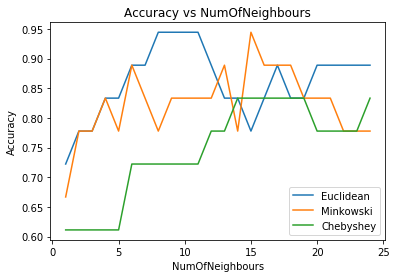

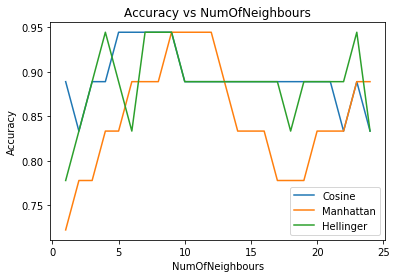

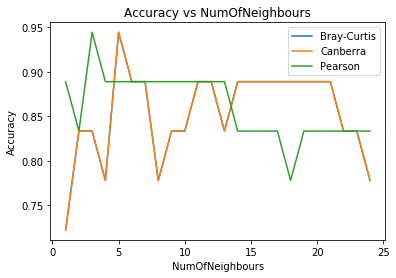

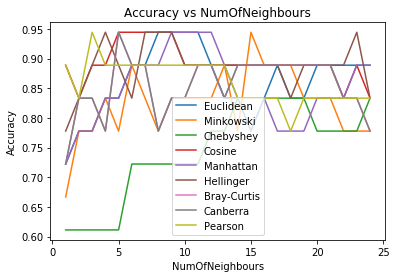

In [212]:
fig, ax = plt.subplots()
for j in distanceMeasures[0:3]:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');
fig, ax = plt.subplots()
for j in distanceMeasures[3:6]:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');
fig, ax = plt.subplots()
for j in distanceMeasures[6:10]:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');
fig, ax = plt.subplots()
for j in distanceMeasures:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');

In [30]:
GivenDataSet

,class,a1,a2,a3,a4,a5,a6,Id,predict
0,1,1,1,1,3,2,1,data_19,0
1,1,1,2,1,1,1,2,data_50,1
2,0,1,2,1,2,3,2,data_62,0
3,0,1,2,2,2,4,2,data_88,0
4,0,1,3,1,3,2,2,data_116,1
5,0,1,3,1,3,4,2,data_120,0
6,0,1,3,2,1,2,2,data_124,0
7,1,1,3,2,2,1,2,data_130,1
8,0,1,3,2,2,3,2,data_134,0
9,0,2,1,1,1,3,2,data_150,0


In [ ]:

def NumberOfEachClass(GivenData):
    NumberOfClassZerosInGivenData = 0
    NumberOfClassOnesInGivenData = 0
    for i in list(GivenData.index.values):
        if GivenData.at[int(i),'class'] == 0:
            NumberOfClassZerosInGivenData += 1
        else:
            NumberOfClassOnesInGivenData += 1
    print('NumberOfClassZerosInGivenData '+str(NumberOfClassZerosInGivenData))
    print('NumberOfClassOnesInGivenData  '+str(NumberOfClassOnesInGivenData))
    print('Class Zeros Percentage '+str(NumberOfClassZerosInGivenData/(NumberOfClassZerosInGivenData+NumberOfClassOnesInGivenData)))
    print('Class Ones Percentage '+str(NumberOfClassOnesInGivenData/(NumberOfClassZerosInGivenData+NumberOfClassOnesInGivenData)))
#NumberOfEachClass(train)
#NumberOfEachClass(val)